In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/air-passengers/AirPassengers.csv
/kaggle/input/flight/flight.csv
/kaggle/input/stock-time-series-20050101-to-20171231/CAT_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/UTX_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/PFE_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/PG_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/UNH_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/JNJ_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/VZ_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/AABA_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/BA_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/KO_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/MCD_2006-01

In [2]:
try:
    import neuralprophet
except:
    !pip install neuralprophet

     |████████████████████████████████| 67 kB 307 kB/s 
     |████████████████████████████████| 165 kB 553 kB/s 
  Attempting uninstall: holidays
    Found existing installation: holidays 0.11.2
    Uninstalling holidays-0.11.2:
      Successfully uninstalled holidays-0.11.2


<hr style="border: solid 3px blue;">

# Introduction

> The data used is a compilation of passengers from January 1949 to December 1960. We want to predict the time series through the RNN model made of simple LTSM for the data.

![](https://insightimi.files.wordpress.com/2020/07/on-de793_201909_g_20190830121038.gif)

Picture Credit: https://insightimi.files.wordpress.com

**What is time series analysis?**
> Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values. While regression analysis is often employed in such a way as to test relationships between one or more different time series, this type of analysis is not usually called "time series analysis", which refers in particular to relationships between different points in time within a single series. Interrupted time series analysis is used to detect changes in the evolution of a time series from before to after some intervention which may affect the underlying variable.

Ref: https://en.wikipedia.org/wiki/Time_series

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch

In [4]:
def plot_decompose(decompose_result):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,20))
    decompose_result.observed.plot(legend=False,ax=ax1,fontsize = 20,grid=True,linewidth = 3)
    ax1.set_ylabel("Observed",fontsize = 20)
    decompose_result.trend.plot(legend=False,ax=ax2,fontsize = 20,grid=True,linewidth = 3)
    ax2.set_ylabel("Trend",fontsize = 20)
    decompose_result.seasonal.plot(legend=False,ax=ax3,fontsize = 20,grid=True,linewidth = 3)
    ax3.set_ylabel("Seasonal",fontsize = 20)
    decompose_result.resid.plot(legend=False,ax=ax4,fontsize = 20,grid=True,linewidth = 3)
    ax4.set_ylabel("Residual",fontsize = 20)

# EDA (Exploratory Data Analysis)

In [5]:
flight_data = pd.read_csv('/kaggle/input/flight/flight.csv')
cm = sns.light_palette("green", as_cmap=True)
flight_data.head(20).style.background_gradient(cmap=cm)

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121
5,1949,June,135
6,1949,July,148
7,1949,August,148
8,1949,September,136
9,1949,October,119


In [6]:
print(flight_data.describe())
print('-'*40)
print(flight_data.tail())

              year  passengers
count   144.000000  144.000000
mean   1954.500000  280.298611
std       3.464102  119.966317
min    1949.000000  104.000000
25%    1951.750000  180.000000
50%    1954.500000  265.500000
75%    1957.250000  360.500000
max    1960.000000  622.000000
----------------------------------------
     year      month  passengers
139  1960     August         606
140  1960  September         508
141  1960    October         461
142  1960   November         390
143  1960   December         432


In [7]:
flight_data.shape

(144, 3)

In [8]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        144 non-null    int64 
 1   month       144 non-null    object
 2   passengers  144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


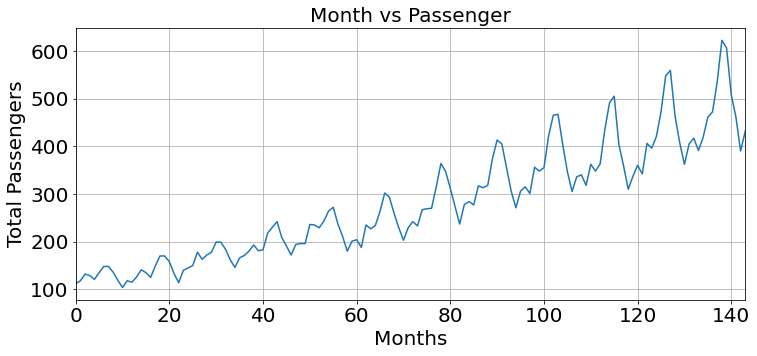

In [9]:
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(flight_data['passengers'])

If you look at the picture above, you can see the periodicity by season. Let's analyze it a bit more using seasonal_decompose,

In [10]:
flight_data['passengers']

0      112
1      118
2      132
3      129
4      121
      ... 
139    606
140    508
141    461
142    390
143    432
Name: passengers, Length: 144, dtype: int64

Let's decompose time series data into Trend, Seasonality, and Residual through time series decomposition.

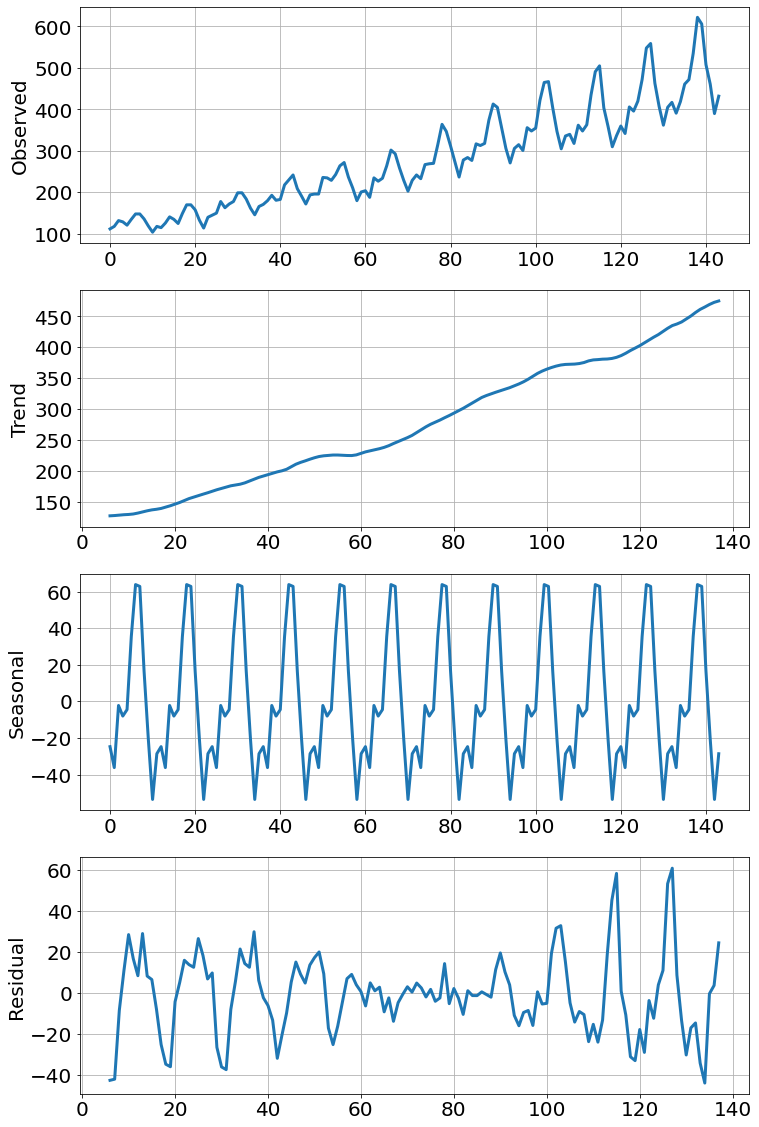

In [11]:
import statsmodels
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(flight_data['passengers'], period=12) 
plot_decompose(decomposition)

As expected, seasonal periodicity was observed. Let's see if our predictive model can learn this periodicity and make a prediction. Also, if you look at the trend line, you can see that the number of customers is gradually increasing.

# Preprocessing

In [12]:
all_data = flight_data['passengers'].values.astype(float)
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


In [13]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [14]:
print(len(train_data))
print(len(test_data))

132
12


Perform Min-Max scaling. 

In this case, the distribution of the dataset is maintained through linear transformation. You can refer to the notebook below for more details.

[preprocessing-linear-nonlinear-scaling](https://www.kaggle.com/ohseokkim/preprocessing-linear-nonlinear-scaling)

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [16]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

# Utility Function

> This function returns a tuple by transforming the raw input data into sequence data to fit training. The number of passengers traveling in the first 12 months predicts the number of passengers in 13 months.
> 
> The first value in tuple: sequence of passengers in 12 months (=features)
> 
> The second value of the tuple: the number of passengers predicted as the number of passengers in 12 months (=target)

In [17]:
train_window = 12

In [18]:
def create_inout_sequences(input_data, window):
    inout_seq = []
    L = len(input_data)
    for i in range(L-window):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window:i+window+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [19]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [20]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077]))]

<hr style="border: solid 3px blue;">

# Modeling using LTSM

![](https://miro.medium.com/max/1400/1*goJVQs-p9kgLODFNyhl9zA.gif)

Picture Credit: https://miro.medium.com

> Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can process not only single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition and anomaly detection in network traffic or IDSs (intrusion detection systems).
> 
> A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.
> 
> LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the vanishing gradient problem that can be encountered when training traditional RNNs. Relative insensitivity to gap length is an advantage of LSTM over RNNs, hidden Markov models and other sequence learning methods in numerous applications.

Ref: https://en.wikipedia.org/wiki/Long_short-term_memory

Modeling is done using a simple LTSM layer.

* Input_size: It corresponds to the number of input sequences. The sequence length is 12, but there is only 1 value per month, i.e. total number of passengers, so the input size is 1.
* Hidden_layer_size: Specifies the number of hidden layers.
* Output_size: The output size is 1 because the number of items in the output predicts the number of passengers in the next month.

In [21]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [22]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=128, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out[:,-1,:])
        return predictions[-1]

In [23]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [24]:
print(model)

LSTM(
  (lstm): LSTM(1, 128, num_layers=2)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


# Training

In [25]:
epochs = 500

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
 
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

epoch:   1 loss: 0.02789364
epoch:  26 loss: 0.00038100
epoch:  51 loss: 0.01521160
epoch:  76 loss: 0.00083448
epoch: 101 loss: 0.00014642
epoch: 126 loss: 0.00004057
epoch: 151 loss: 0.00001299
epoch: 176 loss: 0.00638176
epoch: 201 loss: 0.00005349
epoch: 226 loss: 0.00009776
epoch: 251 loss: 0.00014490
epoch: 276 loss: 0.00165894
epoch: 301 loss: 0.00100665
epoch: 326 loss: 0.00008283
epoch: 351 loss: 0.00013014
epoch: 376 loss: 0.00000280
epoch: 401 loss: 0.00001533
epoch: 426 loss: 0.00061193
epoch: 451 loss: 0.00000169
epoch: 476 loss: 0.00069150
epoch: 499 loss: 0.00018383


# Predicting

The test set contains passenger data for the last 12 months. The model is trained to make predictions using sequence length 12. Let's predict the last 12 months of data.

In [26]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


The test set is run 12 iterations. At the end of the iteration, the test_inputs list contains 24 entries. The last 12 items are the predicted values for the test set.

In [27]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        test_inputs.append(model(seq).item())

Check the last 12 predictions.

In [28]:
test_inputs[fut_pred:]

[0.45563435554504395,
 0.4024431109428406,
 0.62452632188797,
 0.34648656845092773,
 0.3541193902492523,
 0.34167519211769104,
 0.6050803661346436,
 0.8150404095649719,
 0.6349019408226013,
 0.450186550617218,
 0.18475043773651123,
 -0.0460774227976799]

# Converting to real values
Since we normalized the dataset for training, the predicted values are also normalized. We need to transform the normalized predicted values into the actual predicted values. Use the inverse_transform of the min/max scaler object you used to normalize the data set to transform it to its original value.

In [29]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[435.15681589]
 [423.05580774]
 [473.57973823]
 [410.32569432]
 [412.06216128]
 [409.23110621]
 [469.1557833 ]
 [516.92169318]
 [475.94019154]
 [433.91744027]
 [373.53072459]
 [321.01738631]]


In [30]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


# Checking results
The prediction of the LSTM is indicated by the orange line. Although the results are not exact, it is possible to spot an upward trend based on fluctuations in the total number of passengers traveling over the past 12 months. Better performance can be achieved by using a larger number of epochs and a larger number of neurons in the LSTM layer.

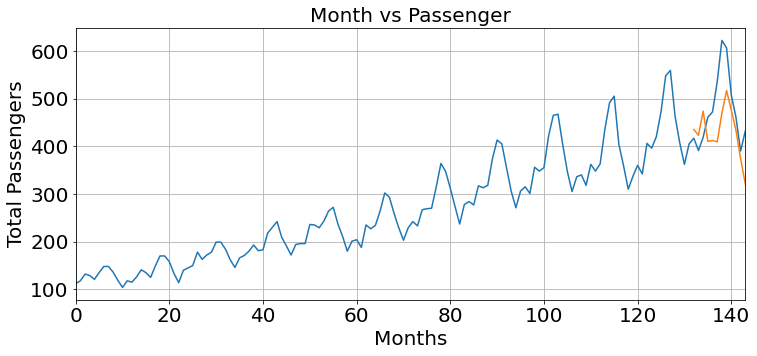

In [31]:
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)

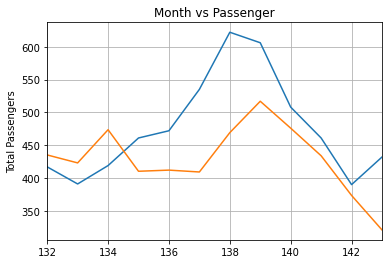

In [32]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

# Time series analysis with predicted results

Check whether the predicted results are learned while preserving the trend, seasonality, and residual of the timer series that the original time series has.

In [33]:
flight_data['passengers'][:-train_window]
train_df = pd.DataFrame(flight_data['passengers'][:-train_window])
actual_df = pd.DataFrame(actual_predictions)
actual_df.columns = ['passengers']
new_predict = pd.concat([train_df,actual_df]).reset_index(drop=True)

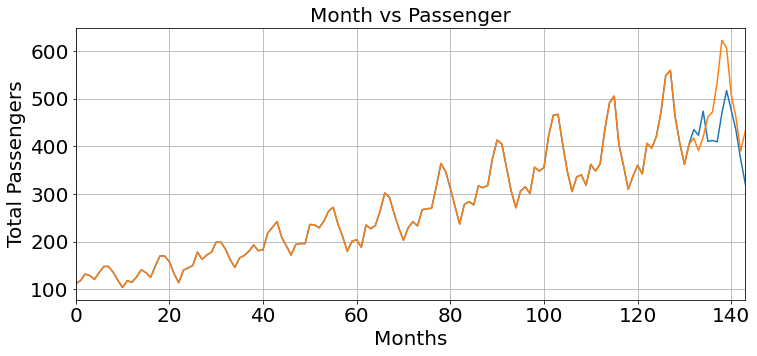

In [34]:
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(new_predict)
plt.plot(flight_data['passengers'])

**Let's do a seasonal decomposition analysis with the predicted results.**

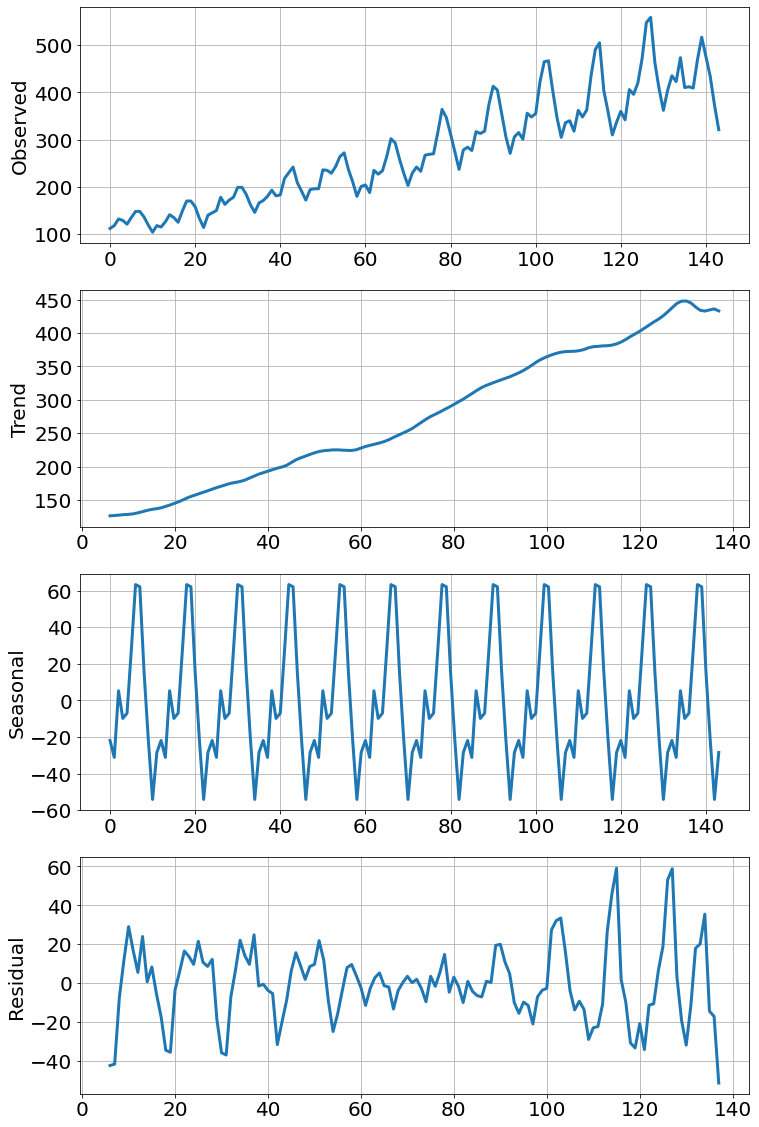

In [35]:
decomposition = seasonal_decompose(new_predict, period=12) 
plot_decompose(decomposition)

Looking at the figure above, it can be confirmed that, despite the simple model, it is predicted while well preserving the trend, seasonality, and residual.

<hr style="border: solid 3px blue;">

# Predicting by Prophet

![](https://miro.medium.com/max/1400/0*CHhERBPfiUJJDJo1.gif)

Picture Credit: https://miro.medium.com

Let's predict using prophet.

> Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. **It works best with time series that have strong seasonal effects and several seasons of historical data.** Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Ref: https://facebook.github.io/prophet/


## Preprocessing

If you try to train using Prophet, you need to change the column and data type according to the conditions required by prophet.

In [36]:
df = flight_data.copy()

In [37]:
month2int = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
df['month'] = df['month'].map(month2int)

In [38]:
df['day'] = 1
df['ds'] = pd.to_datetime(df[['year','month','day']])
df_new = df.drop(columns=['year','month','day'])
df_new.rename(columns={"passengers": "y"},inplace=True)
df_new.head()

,y,ds
0,112,1949-01-01
1,118,1949-02-01
2,132,1949-03-01
3,129,1949-04-01
4,121,1949-05-01


## Trainging

In [39]:
from fbprophet import Prophet 
m = Prophet()
m.fit(df_new)

Initial log joint probability = -2.46502


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        401.66   2.65167e-05        76.716           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       401.802   4.92672e-05       64.6441    4.13e-07       0.001      249  LS failed, Hessian reset 
     199        401.81   6.04457e-05       77.1871           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        401.86   1.62811e-07       70.0399      0.2689           1      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306        401.86   1.44416e-06       88.0691   1.809e-08       0.001      487  LS failed, Hessian reset 
     322        401.86   8.54573e-09       66.0948     0.08165     0.08165      508   
Optimization terminated normally: 
  Convergence detected: abs

## Predicting

In [40]:
future = m.make_future_dataframe(periods=500)
forecast = m.predict(future)

## Checking results

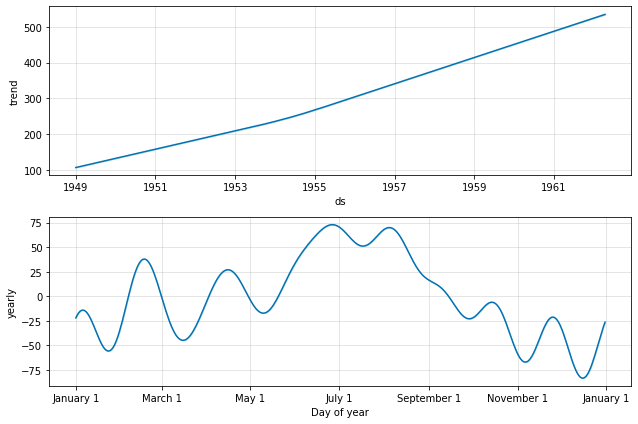

In [41]:
fig2 = m.plot_components(forecast)

In [42]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [43]:
plot_components_plotly(m, forecast)

<hr style="border: solid 3px blue;">

# NeuralProphet

![](https://miro.medium.com/max/1838/1*g_clFunR6GbWU1rL2iGugA.png)

Picture Credit: https://miro.medium.com


> NeuralProphet is a Neural Network based PyTorch implementation of a user-friendly time series forecasting tool for practitioners. This is heavily inspired by Prophet, which is the popular forecasting tool developed by Facebook. NeuralProphet is developed in a fully modular architecture which makes it scalable to add any additional components in the future. Our vision is to develop a simple to use forecasting tool for users while retaining the original objectives of Prophet such as interpretability, configurability and providing much more such as the automatic differencing capabilities by using PyTorch as the backend.

Ref: https://neuralprophet.com

In [44]:
from neuralprophet import NeuralProphet

In [45]:
m = NeuralProphet()
metrics = m.fit(df_new, freq="M")
forecast = m.predict(df_new)

INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 292


  0%|          | 0/209 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.13E-02, min: 6.21E-01


  0%|          | 0/209 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.82E-02, min: 1.86E+00


  0%|          | 0/209 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.69E-02, min: 1.52E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.08E-02
Epoch[292/292]: 100%|██████████| 292/292 [00:05<00:00, 53.52it/s, SmoothL1Loss=0.00153, MAE=16.1, RMSE=20.7, RegLoss=0]


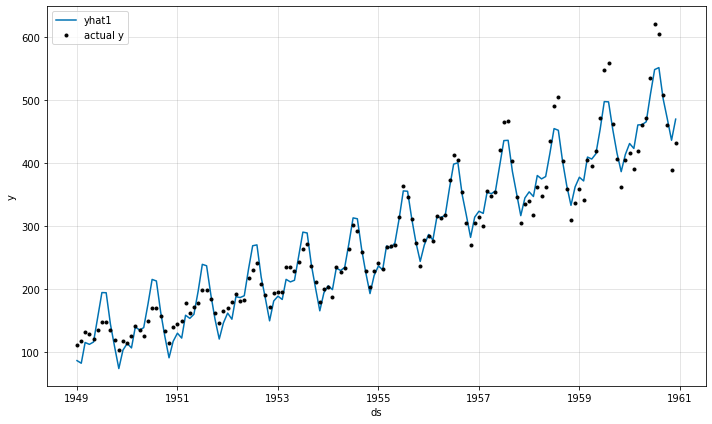

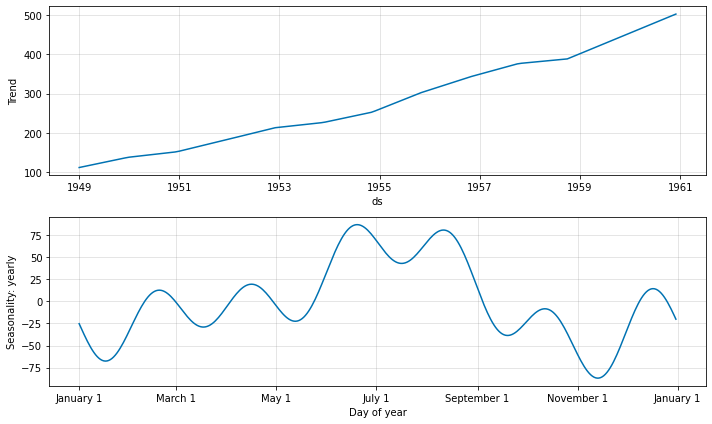

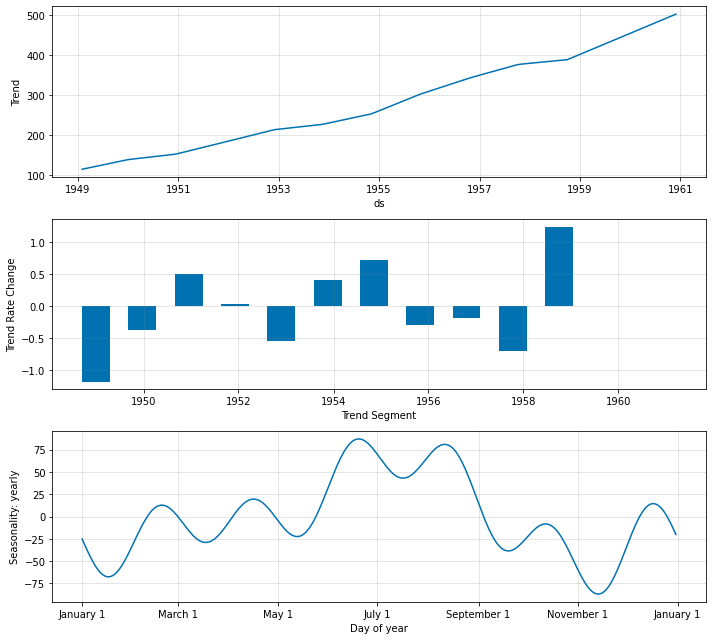

In [46]:
fig_forecast = m.plot(forecast)
fig_components = m.plot_components(forecast)
fig_model = m.plot_parameters()

# Predicting by NeuralProphet

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:552: UserWarning:

Setting attributes on ParameterDict is not supported.




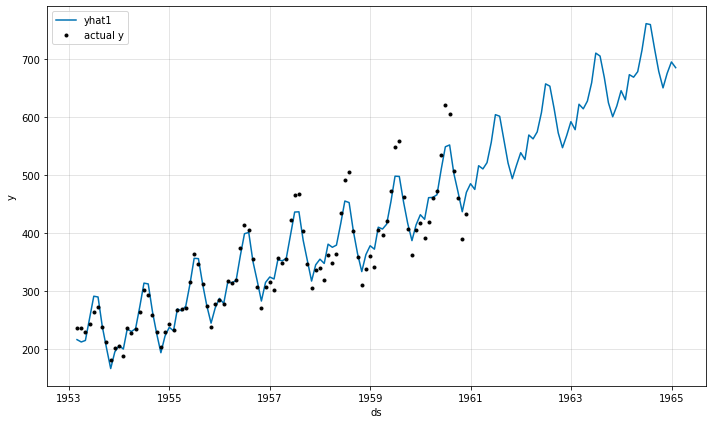

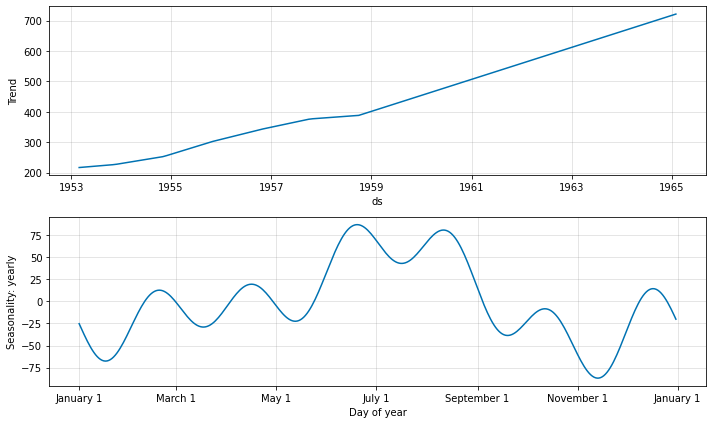

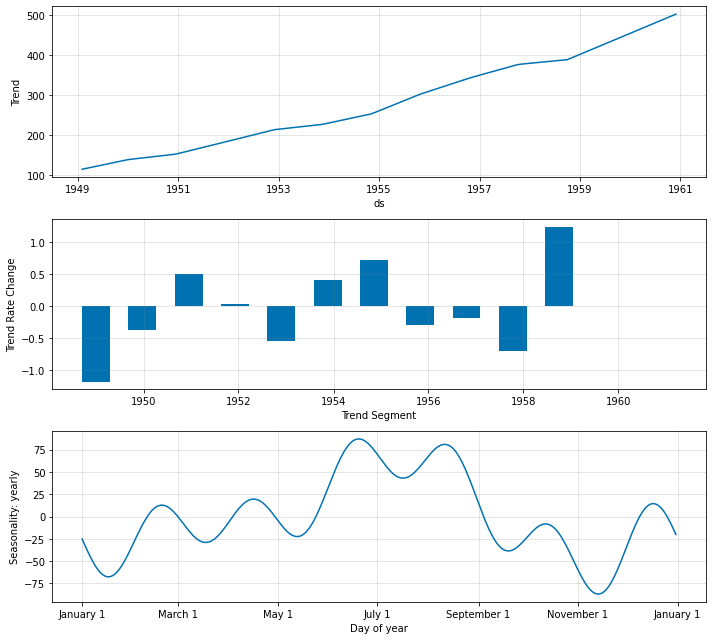

In [47]:
future = m.make_future_dataframe(df_new, periods=50, n_historic_predictions=len(df_new)-50)
forecast = m.predict(future)
fig_forecast = m.plot(forecast)
fig_components = m.plot_components(forecast)
fig_model = m.plot_parameters()

<hr style="border: solid 3px blue;">

# Conclusion

The same dataset was predicted using simple RNN ,prophet and NeuralProphet. All of these methods seem to be predictable. However, it is expected that the predictive power will decrease in datasets that do not have constant trend and seasonality. In other words, it seems that an appropriate method should be selected based on the domain knowledge of the corresponding dataset.
